## Analysis of google reviews

In [379]:
key = pd.read_csv("../raw_data/api_key.csv", header=None)
key = key.loc[0,0]

In [436]:
import pandas as pd
import pickle
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
from sklearn.naive_bayes import MultinomialNB

### import data and drop columns 

In [446]:
df = pd.read_csv("../raw_data/reviews_clean.csv", header=None)

df.columns = ["index0", "index","restaurant_name", "comment_names", "comment_ratings", "comment_dates", "comment_comments"]

df.drop(columns=["index0", "Reviewer"], inplace=True)

KeyError: "['Index' 'Reviewer'] not found in axis"

,Unnamed: 0,index,restaurant_name,comment_names,comment_ratings,comment_dates,comment_comments
0,0,0.0,Augusto Lisboa,Lee Bradshaw,"Rated 5.0 out of 5,",2 weeks ago,Well worth the small wait to get in of around ...
1,1,1.0,Augusto Lisboa,Joel Moralez,"Rated 5.0 out of 5,",5 days ago,Two words: Homemade excellence. This place set...
2,2,2.0,Augusto Lisboa,Carolyn Brosious,"Rated 5.0 out of 5,",6 days ago,"Chic vibe, excellent service, and delicious fo..."
3,3,3.0,Augusto Lisboa,D,"Rated 5.0 out of 5,",2 weeks ago,Some of the best brunch I’ve had! Cheery and c...
4,4,4.0,Augusto Lisboa,Joy Parpan,"Rated 4.0 out of 5,",a week ago,Love the avocado toast! Best cappuccino and th...
...,...,...,...,...,...,...,...
13786,17067,115.0,Moma,Mary O'Mahony,"Rated 1.0 out of 5,",2 years ago,It was worse food ever had
13787,17068,116.0,Moma,Hamid Alagha,"Rated 1.0 out of 5,",2 years ago,You need to watch out for the extra charges. T...
13788,17069,117.0,Moma,Ilari Lehtinen,"Rated 1.0 out of 5,",2 years ago,The worst restaurant I have ever been in.
13789,17070,118.0,Moma,Hayk Bezirganyan,"Rated 1.0 out of 5,",2 years ago,Scammers. Avoid this place.


In [438]:
df_restaurants = pd.read_csv("../raw_data/restaurants2 - Copy.csv", header=None)
df_restaurants.columns = ["Index", "Restaurant", "type", "sub-type", "Score", "Review_count", "cost", "address", "delivery"]


In [439]:
df_restaurants.shape

(21, 9)

In [295]:
!pip install geopy

In [296]:
#Importing the Nominatim geocoder class 
from geopy.geocoders import Nominatim

In [304]:
def address_to_geocode(address):
    try:
        #making an instance of Nominatim class
        geolocator = Nominatim(user_agent="my_request")
        location = geolocator.geocode(address)
        return location.longitude
    except AttributeError:
        pass
        

In [ ]:
!pip install googlemaps

In [431]:
import googlemaps
from datetime import datetime

def latitude(column):
    gmaps = googlemaps.Client(key=key)
    # Geocoding an address
    geocode_result = gmaps.geocode(column)
    return float(geocode_result[0]['geometry']['location']['lat'])

In [432]:
def longitude(column):
    gmaps = googlemaps.Client(key=key)
    # Geocoding an address
    geocode_result = gmaps.geocode(column)
    return float(geocode_result[0]['geometry']['location']['lng'])

In [433]:
df_restaurants['latitude'] = df_restaurants.address.apply(latitude)

In [434]:
df_restaurants['longitude'] = df_restaurants.address.apply(longitude)

In [435]:
df_restaurants

,Index,Restaurant,type,sub-type,Score,Review_count,cost,address,delivery,latitude,longitude
0,0,Augusto Lisboa,Brunch restaurant,"Hip brunch eatery serving savory toasts, banan...",4.8,"1,032 Google reviews",££,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['Dine-in', 'Takeaway', 'No delivery']",38.714376,-9.130176
1,0,Tiffin Cafe & Restaurant Lisboa,Brunch restaurant,NaN,4.9,139 Google reviews,££,"R. do Conde 32, 1200-637 Lisboa, Portugal","['Dine-in', 'Takeaway', 'Delivery']",38.706143,-9.161868
2,0,Crisfama,Restaurant,NaN,4.8,649 Google reviews,£,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['Dine-in', 'Takeaway', 'No delivery']",38.717502,-9.120669
3,0,Alma,Fine dining restaurant,High-end restaurant with avant-garde local mea...,4.8,953 Google reviews,££££,"R. Anchieta 15, 1200-224 Lisboa, Portugal","['Dine-in', 'No takeaway', 'No delivery']",38.710140,-9.141088
4,0,Restaurant CHULHO & Bar,Restaurant,NaN,4.9,180 Google reviews,NaN,"R. de São João da Mata 82, 1200-850 Lisboa, Po...","['Dine-in', 'Takeaway', 'Delivery']",38.707959,-9.158521
5,0,Jam Club,Restaurant,NaN,4.8,664 Google reviews,£,"Tv. Inglesinhos 49, 1200-223 Lisboa, Portugal","['Dine-in', 'Takeaway', 'No delivery']",38.712697,-9.146222
6,0,Ramiro,Seafood restaurant,"Relaxed, informal 3-floor seafood and beer dri...",4.5,"11,612 Google reviews",£££,"Av. Alm. Reis 1 H, 1150-007 Lisboa, Portugal","['Dine-in', 'Drive-through', 'No-contact deliv...",38.720134,-9.135748
7,0,Belcanto,Restaurant,"Chic, wood-paneled dining room serving modern ...",4.6,865 Google reviews,££££,"R. Serpa Pinto 10A, 1200-026 Lisboa, Portugal","['Dine-in', 'No takeaway', 'No delivery']",38.710099,-9.141466
8,0,Feitoria,Portuguese restaurant,"Portuguese fare served in a light-filled, whit...",4.8,357 Google reviews,££££,"Altis Belem Hotel & Spa, Doca do Bom Sucesso, ...","['Dine-in', 'No delivery']",38.693287,-9.210805
9,0,A Cevicheria,Peruvian restaurant,Casual Peruvian spot serving ceviche & seafood...,4.4,"2,674 Google reviews",££,"R. Dom Pedro V 129, 1250-096 Lisboa, Portugal","['Dine-in', 'Takeaway', 'Delivery']",38.715971,-9.147499


In [422]:
import requests

In [425]:
def extract_long_via_address(address_or_zipcode):
    lat, lng = None, None
    api_key = key
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?address={address_or_zipcode}&key={api_key}"
    # see how our endpoint includes our API key? Yes this is yet another reason to restrict the key
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return None, None
    try:
        '''
        This try block incase any of our inputs are invalid. This is done instead
        of actually writing out handlers for all kinds of responses.
        '''
        results = r.json()['results'][0]
        lat = results['geometry']['location']['lat']
        lng = results['geometry']['location']['lng']
    except:
        pass
    return lng

In [ ]:
%%time
df_restaurants['longitude'] = df_restaurants.address.apply(extract_long_via_address)

In [427]:
df_restaurants

,Index,Restaurant,type,sub-type,Score,Review_count,cost,address,delivery,latitude,longitude
0,0,Augusto Lisboa,Brunch restaurant,"Hip brunch eatery serving savory toasts, banan...",4.8,"1,032 Google reviews",££,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['Dine-in', 'Takeaway', 'No delivery']","(38.714376,)",-9.130176
1,0,Tiffin Cafe & Restaurant Lisboa,Brunch restaurant,NaN,4.9,139 Google reviews,££,"R. do Conde 32, 1200-637 Lisboa, Portugal","['Dine-in', 'Takeaway', 'Delivery']","(38.7061433,)",-9.161868
2,0,Crisfama,Restaurant,NaN,4.8,649 Google reviews,£,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['Dine-in', 'Takeaway', 'No delivery']","(38.7175022,)",-9.120669
3,0,Alma,Fine dining restaurant,High-end restaurant with avant-garde local mea...,4.8,953 Google reviews,££££,"R. Anchieta 15, 1200-224 Lisboa, Portugal","['Dine-in', 'No takeaway', 'No delivery']","(38.7101401,)",-9.141088
4,0,Restaurant CHULHO & Bar,Restaurant,NaN,4.9,180 Google reviews,NaN,"R. de São João da Mata 82, 1200-850 Lisboa, Po...","['Dine-in', 'Takeaway', 'Delivery']","(38.7079592,)",-9.158521
5,0,Jam Club,Restaurant,NaN,4.8,664 Google reviews,£,"Tv. Inglesinhos 49, 1200-223 Lisboa, Portugal","['Dine-in', 'Takeaway', 'No delivery']","(38.7126972,)",-9.146222
6,0,Ramiro,Seafood restaurant,"Relaxed, informal 3-floor seafood and beer dri...",4.5,"11,612 Google reviews",£££,"Av. Alm. Reis 1 H, 1150-007 Lisboa, Portugal","['Dine-in', 'Drive-through', 'No-contact deliv...","(38.7201344,)",-9.135748
7,0,Belcanto,Restaurant,"Chic, wood-paneled dining room serving modern ...",4.6,865 Google reviews,££££,"R. Serpa Pinto 10A, 1200-026 Lisboa, Portugal","['Dine-in', 'No takeaway', 'No delivery']","(38.7100994,)",-9.141466
8,0,Feitoria,Portuguese restaurant,"Portuguese fare served in a light-filled, whit...",4.8,357 Google reviews,££££,"Altis Belem Hotel & Spa, Doca do Bom Sucesso, ...","['Dine-in', 'No delivery']","(38.6932869,)",-9.210805
9,0,A Cevicheria,Peruvian restaurant,Casual Peruvian spot serving ceviche & seafood...,4.4,"2,674 Google reviews",££,"R. Dom Pedro V 129, 1250-096 Lisboa, Portugal","['Dine-in', 'Takeaway', 'Delivery']","(38.71597089999999,)",-9.147499


In [320]:
df_restaurants.longitude.isna().sum()

In [318]:
df_restaurants.shape

(21, 10)

<AxesSubplot:>

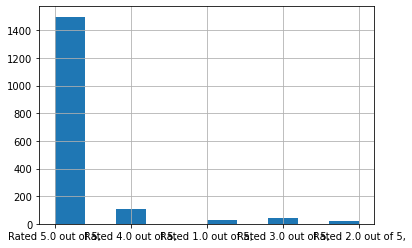

In [228]:
df.Score.hist()

In [229]:
df.shape

(1694, 4)

In [230]:
df.drop_duplicates(inplace=True)

In [231]:
df.shape

(1668, 4)

In [232]:
cleaned_df = df.dropna()

### Score column

In [233]:
cleaned_df.Score.unique()

array(['Rated 5.0 out of 5,', 'Rated 4.0 out of 5,',
       'Rated 1.0 out of 5,', 'Rated 3.0 out of 5,',
       'Rated 2.0 out of 5,'], dtype=object)

In [234]:
def extract_score(series):
    return float(series[6:9])

In [235]:
cleaned_df['Score'] = cleaned_df['Score'].apply(extract_score)

/tmp/ipykernel_5479/3020042498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Score'] = cleaned_df['Score'].apply(extract_score)


In [236]:
cleaned_df.head()

,Restaurant,Score,When,Review
0,Augusto Lisboa,5.0,2 weeks ago,Well worth the small wait to get in of around ...
1,Augusto Lisboa,5.0,5 days ago,Two words: Homemade excellence. This place set...
2,Augusto Lisboa,5.0,6 days ago,"Chic vibe, excellent service, and delicious fo..."
3,Augusto Lisboa,5.0,2 weeks ago,Some of the best brunch I’ve had! Cheery and c...
4,Augusto Lisboa,4.0,a week ago,Love the avocado toast! Best cappuccino and th...


array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

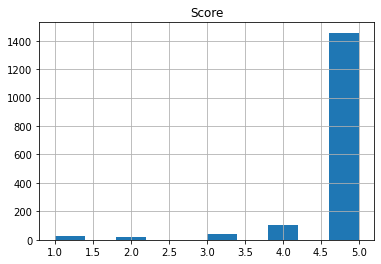

In [237]:
cleaned_df.hist()

### Clean Reviews

In [238]:
def remove_google_trans_comment(series):
    if "(Traduzido pelo Google)" in series:
        return series.replace("(Traduzido pelo Google) ","")
    else:
        return series    

In [239]:
cleaned_df.Review = cleaned_df.Review.apply(remove_google_trans_comment)

/home/jamie/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [240]:
cleaned_df.reset_index(drop=True)

,Restaurant,Score,When,Review
0,Augusto Lisboa,5.0,2 weeks ago,Well worth the small wait to get in of around ...
1,Augusto Lisboa,5.0,5 days ago,Two words: Homemade excellence. This place set...
2,Augusto Lisboa,5.0,6 days ago,"Chic vibe, excellent service, and delicious fo..."
3,Augusto Lisboa,5.0,2 weeks ago,Some of the best brunch I’ve had! Cheery and c...
4,Augusto Lisboa,4.0,a week ago,Love the avocado toast! Best cappuccino and th...
...,...,...,...,...
1644,Ceia,5.0,3 years ago,(Translated by Google) In a charming space in ...
1645,Ceia,5.0,2 years ago,(Translated by Google) Only one big table. Din...
1646,Ceia,5.0,3 years ago,(Translated by Google) Spectacular space with ...
1647,Ceia,5.0,2 years ago,(Translated by Google) A different experience....


In [241]:
cleaned_df[cleaned_df.Score == 1]

,Restaurant,Score,When,Review
40,Augusto Lisboa,1.0,2 weeks ago,"Proper food, but please create a proper queue...."
244,Crisfama,1.0,a year ago,Big disappointment. The steak I ordered was ra...
273,Alma,1.0,2 months ago,Although Michelin purports to base ratings onl...
291,Alma,1.0,a year ago,Incredibly disappointed. 36 Euro for one cours...
539,Ramiro,1.0,2 weeks ago,This is a complaint comment. We bought four Sp...
640,Belcanto,1.0,a month ago,wrongly awarded michelin stars!. he does not d...
704,Feitoria,1.0,5 months ago,Style over substance. We should have left afte...
705,Feitoria,1.0,a month ago,A pity we could not have dinner there!. My wif...
840,A Cevicheria,1.0,a week ago,Slow and rude service. The bar tender made a g...
844,A Cevicheria,1.0,2 weeks ago,Two hours to wait in line for diner is too muc...


## NLP preproc

In [242]:
good_scores = cleaned_df[ cleaned_df.Score >=4]

In [243]:
bad_scores = cleaned_df[ cleaned_df.Score <4]

In [244]:
def clean (text):
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
        
    lowercased = text.lower() # Lower Case
    
    #unaccented_string = unidecode.unidecode(lowercased) # remove accents
    
    tokenized = word_tokenize(lowercased) # Tokenize
    
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    
    stop_words = set(stopwords.words('english')) # Make stopword list
    
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    
    return " ".join(without_stopwords)

In [245]:
good_scores['cleaned_reviews'] = good_scores['Review'].apply(clean)
good_scores.head()

/tmp/ipykernel_5479/1163277420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_scores['cleaned_reviews'] = good_scores['Review'].apply(clean)


,Restaurant,Score,When,Review,cleaned_reviews
0,Augusto Lisboa,5.0,2 weeks ago,Well worth the small wait to get in of around ...,well worth small wait get around mins well loo...
1,Augusto Lisboa,5.0,5 days ago,Two words: Homemade excellence. This place set...,two words homemade excellence place sets bar e...
2,Augusto Lisboa,5.0,6 days ago,"Chic vibe, excellent service, and delicious fo...",chic vibe excellent service delicious food got...
3,Augusto Lisboa,5.0,2 weeks ago,Some of the best brunch I’ve had! Cheery and c...,best brunch cheery comfortable ambiance well e...
4,Augusto Lisboa,4.0,a week ago,Love the avocado toast! Best cappuccino and th...,love avocado toast best cappuccino banana brea...


In [246]:
bad_scores['cleaned_reviews'] = bad_scores['Review'].apply(clean)
bad_scores.head()

/tmp/ipykernel_5479/3365364549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_scores['cleaned_reviews'] = bad_scores['Review'].apply(clean)


,Restaurant,Score,When,Review,cleaned_reviews
40,Augusto Lisboa,1.0,2 weeks ago,"Proper food, but please create a proper queue....",proper food please create proper queue inform ...
50,Augusto Lisboa,3.0,a month ago,"It was ok. Surprised the ratings were so high,...",ok surprised ratings high food ok place trendy...
58,Augusto Lisboa,3.0,2 months ago,The waitress who seated us was very nice but t...,waitress seated us nice waitress served us see...
244,Crisfama,1.0,a year ago,Big disappointment. The steak I ordered was ra...,big disappointment steak ordered raw fat refry...
257,Crisfama,2.0,4 years ago,Amazing food... but we were not treated well b...,amazing food treated well boyfriend brazil own...


## Tfidf

In [280]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tuned TFidfvectorizer
def Tfidf_fit(series):
    vec = TfidfVectorizer(ngram_range = (3,3), min_df=0.01).fit(series)
    return vec

def transform_create_list(series):
    vectors = Tfidf_fit(series).transform(series) # Transform text to vectors

    sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

    tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     Tfidf_fit(series).vocabulary_.items()]  # Get the word and associated weight

    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

    return sorted_tfidf_list

In [281]:
Tfidf_fit(good_scores.cleaned_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.01, ngram_range=(3, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [282]:
transform_create_list(good_scores.cleaned_reviews)[:15]

[('food great service', 16.0)]

In [283]:
Tfidf_fit(bad_scores.cleaned_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.01, ngram_range=(3, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [284]:
transform_create_list(bad_scores.cleaned_reviews)[:15]

[('beautiful food bit', 0.7071067811865476),
 ('food bit rich', 0.7071067811865476),
 ('heard good things', 0.7071067811865476),
 ('good things expected', 0.7071067811865476),
 ('ok food pedantic', 0.7071067811865476),
 ('food pedantic service', 0.7071067811865476),
 ('extremely overrated nothing', 0.5773502691896257),
 ('overrated nothing special', 0.5773502691896257),
 ('nothing special food', 0.5773502691896257),
 ('overpriced delivered ceviche', 0.5),
 ('delivered ceviche good', 0.5),
 ('ceviche good amazing', 0.5),
 ('good amazing recommend', 0.5),
 ('tiny place delicious', 0.5),
 ('place delicious traditional', 0.5)]

## TMultibinomial

In [ ]:
cleaned_df